# Dicke model 

Inspired by J. R. Johansson (robert@riken.jp),  [from this notebook](http://github.com/jrjohansson/qutip-lectures).


In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [14]:
from qutip import *

## Introduction

The Dicke Hamiltonian consists of a cavity mode and $N$ spin-1/2 coupled to the cavity:

<center>
$\displaystyle H_D = \omega_0 \sum_{i=1}^N \sigma_z^{(i)} + \omega a^\dagger a + \sum_{i}^N \frac{\lambda}{\sqrt{N}}(a + a^\dagger)(\sigma_+^{(i)}+\sigma_-^{(i)})$

$\displaystyle H_D = \omega_0 J_z + \omega a^\dagger a +  \frac{\lambda}{\sqrt{N}}(a + a^\dagger)(J_+ + J_-)$
</center>
    
where $J_z$ and $J_\pm$ are the collective angular momentum operators for a pseudospin of length $j=N/2$ :

<center>
$\displaystyle J_z = \sum_{i=1}^N \sigma_z^{(i)}$

$\displaystyle J_\pm = \sum_{i=1}^N \sigma_\pm^{(i)}$
</center>

### References

 * [R.H. Dicke, Phys. Rev. 93, 99–110 (1954)](http://dx.doi.org/10.1103/PhysRev.93.99)

## Setup problem in QuTiP

In [15]:
w  = 1.0
w0 = 1.0

g = 1.0
gc = np.sqrt(w * w0)/2 # critical coupling strength

kappa = 0.05 
gamma = 0.15

In [21]:
M = 16  #max number of photons (excitation of the boson field)
N = 4   #number of spoin-1/2
j = N/2.0
n = 2*j + 1

'I feel like that we are not considering the singlet and all the other j<2 states creating j'

a  = tensor(destroy(M), qeye(n))
Jp = tensor(qeye(M), jmat(j, '+'))   #jmat is a functin to create the total angular momentum operator
Jm = tensor(qeye(M), jmat(j, '-'))
Jz = tensor(qeye(M), jmat(j, 'z'))

H0 = w * a.dag() * a + w0 * Jz
H1 = 1.0 / np.sqrt(N) * (a + a.dag()) * (Jp + Jm)
H = H0 + g * H1

H

Quantum object: dims = [[16, 5], [16, 5]], shape = (80, 80), type = oper, isherm = True
Qobj data =
[[ 2.  0.  0. ...  0.  0.  0.]
 [ 0.  1.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... 15.  0.  0.]
 [ 0.  0.  0. ...  0. 14.  0.]
 [ 0.  0.  0. ...  0.  0. 13.]]

### Structure of the Hamiltonian

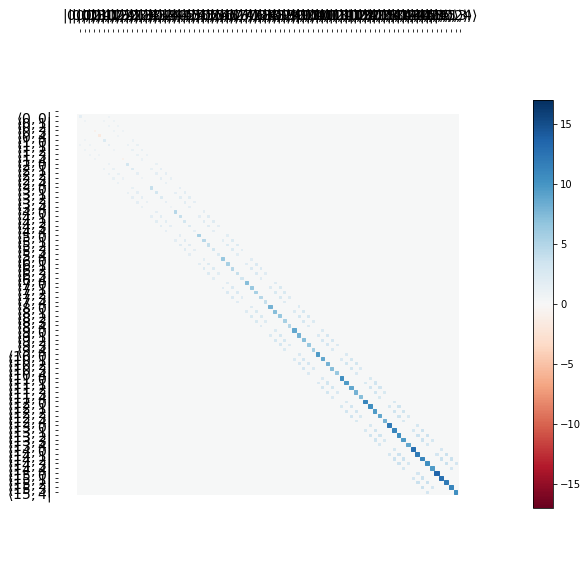

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
hinton(H, ax=ax);

## Find the ground state as a function of cavity-spin interaction strength

In [20]:
g_vec = np.linspace(0.01, 1.0, 20)

# Ground state and steady state for the Hamiltonian: H = H0 + g * H1V
psi_gnd_list = [(H0 + g * H1).groundstate()[1] for g in g_vec]


## Cavity ground state occupation probability

In [26]:
n_gnd_vec = expect(a.dag() * a, psi_gnd_list)  
Jz_gnd_vec = expect(Jz, psi_gnd_list)  

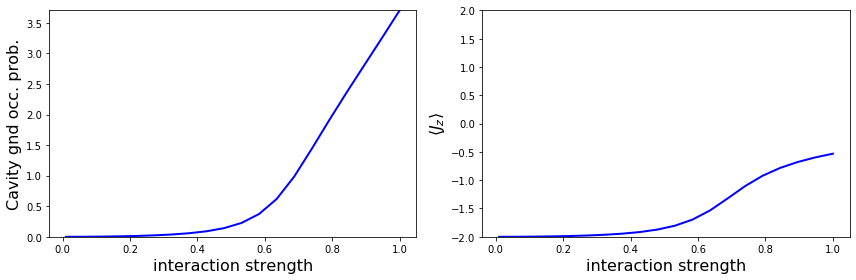

In [27]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12,4))

axes[0].plot(g_vec, n_gnd_vec, 'b', linewidth=2, label="cavity occupation")
axes[0].set_ylim(0, max(n_gnd_vec))
axes[0].set_ylabel("Cavity gnd occ. prob.", fontsize=16)
axes[0].set_xlabel("interaction strength", fontsize=16)

axes[1].plot(g_vec, Jz_gnd_vec, 'b', linewidth=2, label="cavity occupation")
axes[1].set_ylim(-j, j)
axes[1].set_ylabel(r"$\langle J_z\rangle$", fontsize=16)
axes[1].set_xlabel("interaction strength", fontsize=16)

fig.tight_layout()

## Cavity Wigner function and Fock distribution as a function of coupling strength

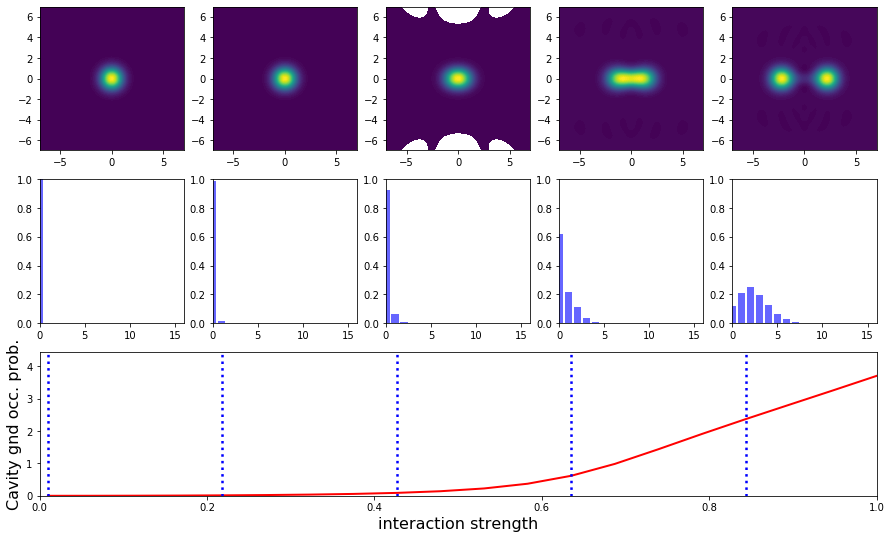

In [28]:
psi_gnd_sublist = psi_gnd_list[::4]

xvec = np.linspace(-7,7,200)

fig_grid = (3, len(psi_gnd_sublist))
fig = plt.figure(figsize=(3*len(psi_gnd_sublist),9))

for idx, psi_gnd in enumerate(psi_gnd_sublist):

    # trace out the cavity density matrix
    rho_gnd_cavity = ptrace(psi_gnd, 0)
    
    # calculate its wigner function
    W = wigner(rho_gnd_cavity, xvec, xvec)
    
    # plot its wigner function
    ax = plt.subplot2grid(fig_grid, (0, idx))
    ax.contourf(xvec, xvec, W, 100)

    # plot its fock-state distribution
    ax = plt.subplot2grid(fig_grid, (1, idx))
    ax.bar(np.arange(0, M), np.real(rho_gnd_cavity.diag()), color="blue", alpha=0.6)
    ax.set_ylim(0, 1)
    ax.set_xlim(0, M)    
    
# plot the cavity occupation probability in the ground state
ax = plt.subplot2grid(fig_grid, (2, 0), colspan=fig_grid[1])
ax.plot(g_vec, n_gnd_vec, 'r', linewidth=2, label="cavity occupation")
ax.set_xlim(0, max(g_vec))
ax.set_ylim(0, max(n_gnd_vec)*1.2)
ax.set_ylabel("Cavity gnd occ. prob.", fontsize=16)
ax.set_xlabel("interaction strength", fontsize=16)

for g in g_vec[::4]:
    ax.plot([g,g],[0,max(n_gnd_vec)*1.2], 'b:', linewidth=2.5)

### Entropy/Entanglement between spins and cavity

In [29]:
entropy_tot    = np.zeros(shape(g_vec))
entropy_cavity = np.zeros(shape(g_vec))
entropy_spin   = np.zeros(shape(g_vec))

for idx, psi_gnd in enumerate(psi_gnd_list):

    rho_gnd_cavity = ptrace(psi_gnd, 0)
    rho_gnd_spin   = ptrace(psi_gnd, 1)
    
    entropy_tot[idx]    = entropy_vn(psi_gnd, 2)
    entropy_cavity[idx] = entropy_vn(rho_gnd_cavity, 2)
    entropy_spin[idx]   = entropy_vn(rho_gnd_spin, 2)

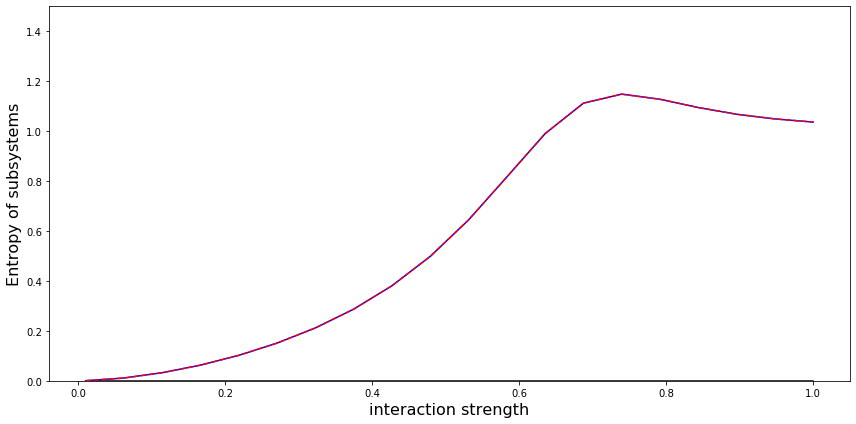

In [30]:
fig, axes = plt.subplots(1, 1, figsize=(12,6))
axes.plot(g_vec, entropy_tot, 'k', g_vec, entropy_cavity, 'b', g_vec, entropy_spin, 'r--')

axes.set_ylim(0, 1.5)
axes.set_ylabel("Entropy of subsystems", fontsize=16)
axes.set_xlabel("interaction strength", fontsize=16)

fig.tight_layout()

# Entropy as a function interaction strength for increasing N

### References

* [Lambert et al., Phys. Rev. Lett. 92, 073602 (2004)](http://dx.doi.org/10.1103/PhysRevLett.92.073602).

In [31]:
def calulcate_entropy(M, N, g_vec):
    
    j = N/2.0
    n = 2*j + 1

    # setup the hamiltonian for the requested hilbert space sizes
    a  = tensor(destroy(M), qeye(n))
    Jp = tensor(qeye(M), jmat(j, '+'))
    Jm = tensor(qeye(M), jmat(j, '-'))
    Jz = tensor(qeye(M), jmat(j, 'z'))

    H0 = w * a.dag() * a + w0 * Jz
    H1 = 1.0 / sqrt(N) * (a + a.dag()) * (Jp + Jm)

    # Ground state and steady state for the Hamiltonian: H = H0 + g * H1
    psi_gnd_list = [(H0 + g * H1).groundstate()[1]  for g in g_vec]
    
    entropy_cavity = zeros(shape(g_vec))
    entropy_spin   = zeros(shape(g_vec))

    for idx, psi_gnd in enumerate(psi_gnd_list):

        rho_gnd_cavity = ptrace(psi_gnd, 0)
        rho_gnd_spin   = ptrace(psi_gnd, 1)
    
        entropy_cavity[idx] = entropy_vn(rho_gnd_cavity, 2)
        entropy_spin[idx]   = entropy_vn(rho_gnd_spin, 2)
        
    return entropy_cavity, entropy_spin

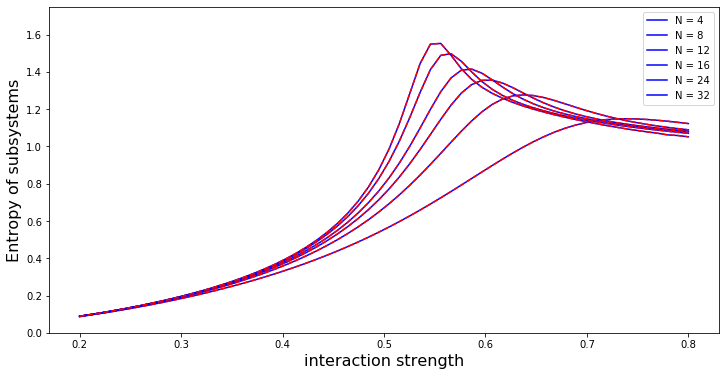

In [32]:
g_vec = np.linspace(0.2, 0.8, 60)
N_vec = [4, 8, 12, 16, 24, 32]
MM = 25

fig, axes = plt.subplots(1, 1, figsize=(12,6))

for NN in N_vec:
    
    entropy_cavity, entropy_spin = calulcate_entropy(MM, NN, g_vec)
    
    axes.plot(g_vec, entropy_cavity, 'b', label="N = %d" % NN)
    axes.plot(g_vec, entropy_spin, 'r--')

axes.set_ylim(0, 1.75)
axes.set_ylabel("Entropy of subsystems", fontsize=16)
axes.set_xlabel("interaction strength", fontsize=16)
axes.legend()

# Dissipative cavity: steady state instead of the ground state

In [18]:
# average number thermal photons in the bath coupling to the resonator
n_th = 0.25

c_ops = [sqrt(kappa * (n_th + 1)) * a, sqrt(kappa * n_th) * a.dag()]
#c_ops = [sqrt(kappa) * a, sqrt(gamma) * Jm]

## Find the ground state as a function of cavity-spin interaction strength

In [19]:
g_vec = np.linspace(0.01, 1.0, 20)

# Ground state for the Hamiltonian: H = H0 + g * H1
rho_ss_list = [steadystate(H0 + g * H1, c_ops) for g in g_vec]

## Cavity ground state occupation probability

In [20]:
# calculate the expectation value of the number of photons in the cavity
n_ss_vec = expect(a.dag() * a, rho_ss_list)

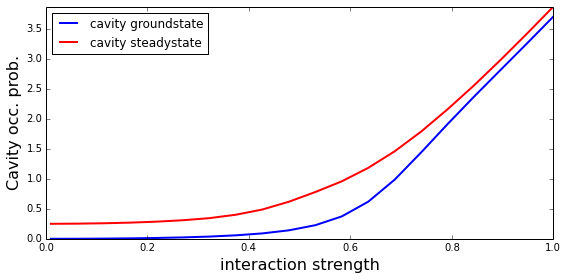

In [21]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,4))

axes.plot(g_vec, n_gnd_vec,'b', linewidth=2, label="cavity groundstate")
axes.plot(g_vec, n_ss_vec, 'r', linewidth=2, label="cavity steadystate")
axes.set_ylim(0, max(n_ss_vec))
axes.set_ylabel("Cavity occ. prob.", fontsize=16)
axes.set_xlabel("interaction strength", fontsize=16)
axes.legend(loc=0)

fig.tight_layout()

## Cavity Wigner function and Fock distribution as a function of coupling strength

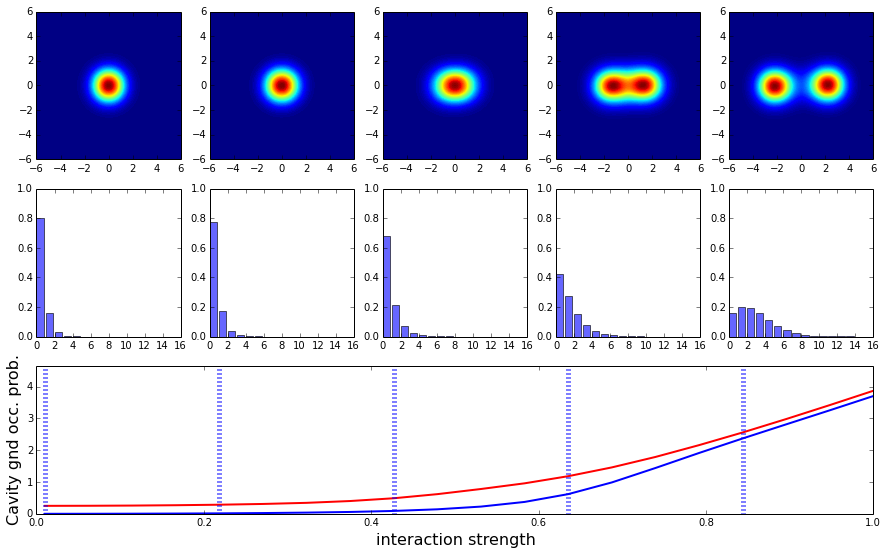

In [23]:
rho_ss_sublist = rho_ss_list[::4]

xvec = np.linspace(-6,6,200)

fig_grid = (3, len(rho_ss_sublist))
fig = plt.figure(figsize=(3*len(rho_ss_sublist),9))

for idx, rho_ss in enumerate(rho_ss_sublist):

    # trace out the cavity density matrix
    rho_ss_cavity = ptrace(rho_ss, 0)
    
    # calculate its wigner function
    W = wigner(rho_ss_cavity, xvec, xvec)
    
    # plot its wigner function
    ax = plt.subplot2grid(fig_grid, (0, idx))
    ax.contourf(xvec, xvec, W, 100)

    # plot its fock-state distribution
    ax = plt.subplot2grid(fig_grid, (1, idx))
    ax.bar(arange(0, M), real(rho_ss_cavity.diag()), color="blue", alpha=0.6)
    ax.set_ylim(0, 1)
    
# plot the cavity occupation probability in the ground state
ax = plt.subplot2grid(fig_grid, (2, 0), colspan=fig_grid[1])
ax.plot(g_vec, n_gnd_vec,'b', linewidth=2, label="cavity groundstate")
ax.plot(g_vec, n_ss_vec, 'r', linewidth=2, label="cavity steadystate")
ax.set_xlim(0, max(g_vec))
ax.set_ylim(0, max(n_ss_vec)*1.2)
ax.set_ylabel("Cavity gnd occ. prob.", fontsize=16)
ax.set_xlabel("interaction strength", fontsize=16)

for g in g_vec[::4]:
    ax.plot([g,g],[0,max(n_ss_vec)*1.2], 'b:', linewidth=5)

## Entropy

In [24]:
entropy_tot    = zeros(shape(g_vec))
entropy_cavity = zeros(shape(g_vec))
entropy_spin   = zeros(shape(g_vec))

for idx, rho_ss in enumerate(rho_ss_list):

    rho_gnd_cavity = ptrace(rho_ss, 0)
    rho_gnd_spin   = ptrace(rho_ss, 1)
    
    entropy_tot[idx]    = entropy_vn(rho_ss, 2)
    entropy_cavity[idx] = entropy_vn(rho_gnd_cavity, 2)
    entropy_spin[idx]   = entropy_vn(rho_gnd_spin, 2)

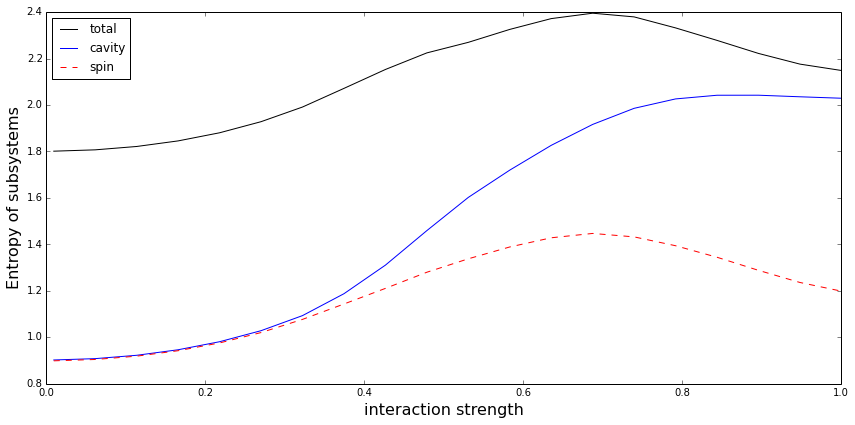

In [25]:
fig, axes = plt.subplots(1, 1, figsize=(12,6))

axes.plot(g_vec, entropy_tot, 'k', label="total")
axes.plot(g_vec, entropy_cavity, 'b', label="cavity")
axes.plot(g_vec, entropy_spin, 'r--', label="spin")

axes.set_ylabel("Entropy of subsystems", fontsize=16)
axes.set_xlabel("interaction strength", fontsize=16)
axes.legend(loc=0)
fig.tight_layout()

### Software versions

In [26]:
from qutip.ipynbtools import version_table

version_table()